In [1]:
1

1

In [2]:
import sys
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import glob
import os

In [3]:
!pip install topaz-em mrcfile

     |████████████████████████████████| 48.2 MB 1.8 MB/s            
     |████████████████████████████████| 40 kB 14 kB/s              


In [4]:
import matplotlib.pyplot as plt

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float , img_as_ubyte
from skimage.util import random_noise
import numpy as np
from skimage.morphology import (square, rectangle, diamond, disk, cube,
                                octahedron, ball, octagon, star)
import skimage
import skimage.filters
from topaz.utils.data.loader import load_image
from topaz.mrc import parse
import numpy as np
import mrcfile

In [5]:
# genearate 0 matrix of SIZE
SIZE = 256;
Init_Matrix = np.zeros((SIZE, SIZE))
# random rectangles in matrix
NUMBER_OF_RECTANGLES = 30;
MAX_Rectangle_Size = 10;
for i in range(NUMBER_OF_RECTANGLES):
    x = np.random.randint(0, SIZE)
    y = np.random.randint(0, SIZE)
    w = MAX_Rectangle_Size
    h = MAX_Rectangle_Size
    Init_Matrix[x:x+w, y:y+h] = 1

with open('../input/cleanset/noised/1KP8-Ap1-pj_90.mrc', 'rb') as f:
    data = f.read()

array, header, extended_header = parse(data)
Init_Matrix = array/array.max()

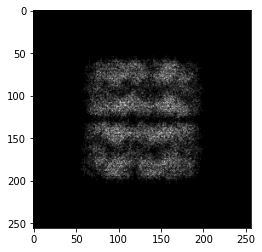

In [6]:
plt.imshow(Init_Matrix, cmap='gray')

In [7]:
!rm -rf datasetA
!rm -rf datasetB
!rm -rf model
!mkdir datasetA
!mkdir datasetB
!mkdir model

In [8]:
for index in range(1, 11):
    with mrcfile.new("./datasetA/tmp"+str(index)+".mrc") as mrc:
        noised = Init_Matrix + 0.5*random_noise(np.zeros((SIZE,SIZE)),mode='gaussian', mean=0, var=1)
        mrc.set_data(noised.astype(np.float32))
    with mrcfile.new("./datasetB/tmp"+str(index)+".mrc") as mrc:
        noised = Init_Matrix + 0.5*random_noise(np.zeros((SIZE,SIZE)),mode='gaussian', mean=0, var=1)
        mrc.set_data(noised.astype(np.float32))

In [9]:

class UDenoiseNet(nn.Module):
    # U-net from noise2noise paper
    def __init__(self, nf=48, base_width=11, top_width=3):
        super(UDenoiseNet, self).__init__()

        self.enc1 = nn.Sequential( nn.Conv2d(1, nf, base_width, padding=base_width//2)
                                 , nn.LeakyReLU(0.1)
                                 , nn.MaxPool2d(2)
                                 )
        self.enc2 = nn.Sequential( nn.Conv2d(nf, nf, 3, padding=1)
                                 , nn.LeakyReLU(0.1)
                                 , nn.MaxPool2d(2)
                                 )
        self.enc3 = nn.Sequential( nn.Conv2d(nf, nf, 3, padding=1)
                                 , nn.LeakyReLU(0.1)
                                 , nn.MaxPool2d(2)
                                 )
        self.enc4 = nn.Sequential( nn.Conv2d(nf, nf, 3, padding=1)
                                 , nn.LeakyReLU(0.1)
                                 , nn.MaxPool2d(2)
                                 )
        self.enc5 = nn.Sequential( nn.Conv2d(nf, nf, 3, padding=1)
                                 , nn.LeakyReLU(0.1)
                                 , nn.MaxPool2d(2)
                                 )
        self.enc6 = nn.Sequential( nn.Conv2d(nf, nf, 3, padding=1)
                                 , nn.LeakyReLU(0.1)
                                 )

        self.dec5 = nn.Sequential( nn.Conv2d(2*nf, 2*nf, 3, padding=1)
                                 , nn.LeakyReLU(0.1)
                                 , nn.Conv2d(2*nf, 2*nf, 3, padding=1)
                                 , nn.LeakyReLU(0.1)
                                 )
        self.dec4 = nn.Sequential( nn.Conv2d(3*nf, 2*nf, 3, padding=1)
                                 , nn.LeakyReLU(0.1)
                                 , nn.Conv2d(2*nf, 2*nf, 3, padding=1)
                                 , nn.LeakyReLU(0.1)
                                 )
        self.dec3 = nn.Sequential( nn.Conv2d(3*nf, 2*nf, 3, padding=1)
                                 , nn.LeakyReLU(0.1)
                                 , nn.Conv2d(2*nf, 2*nf, 3, padding=1)
                                 , nn.LeakyReLU(0.1)
                                 )
        self.dec2 = nn.Sequential( nn.Conv2d(3*nf, 2*nf, 3, padding=1)
                                 , nn.LeakyReLU(0.1)
                                 , nn.Conv2d(2*nf, 2*nf, 3, padding=1)
                                 , nn.LeakyReLU(0.1)
                                 )
        self.dec1 = nn.Sequential( nn.Conv2d(2*nf+1, 64, top_width, padding=top_width//2)
                                 , nn.LeakyReLU(0.1)
                                 , nn.Conv2d(64, 32, top_width, padding=top_width//2)
                                 , nn.LeakyReLU(0.1)
                                 , nn.Conv2d(32, 1, top_width, padding=top_width//2)
                                 )

    def forward(self, x):
        # downsampling
        p1 = self.enc1(x)
        p2 = self.enc2(p1)
        p3 = self.enc3(p2)
        p4 = self.enc4(p3)
        p5 = self.enc5(p4)
        h = self.enc6(p5)

        # upsampling
        n = p4.size(2)
        m = p4.size(3)
        h = F.interpolate(h, size=(n,m), mode='nearest')
        h = torch.cat([h, p4], 1)

        h = self.dec5(h)

        n = p3.size(2)
        m = p3.size(3)
        h = F.interpolate(h, size=(n,m), mode='nearest')
        h = torch.cat([h, p3], 1)

        h = self.dec4(h)

        n = p2.size(2)
        m = p2.size(3)
        h = F.interpolate(h, size=(n,m), mode='nearest')
        h = torch.cat([h, p2], 1)

        h = self.dec3(h)

        n = p1.size(2)
        m = p1.size(3)
        h = F.interpolate(h, size=(n,m), mode='nearest')
        h = torch.cat([h, p1], 1)

        h = self.dec2(h)

        n = x.size(2)
        m = x.size(3)
        h = F.interpolate(h, size=(n,m), mode='nearest')
        h = torch.cat([h, x], 1)

        y = self.dec1(h)

        return y

In [10]:

class PairedImages:
    def __init__(self, x, y, crop=800, xform=True, preload=False, cutoff=0):
        self.x = x
        self.y = y
        self.crop = crop
        self.xform = xform
        self.cutoff = cutoff

        self.preload = preload
        if preload:
            self.x = [self.load_image(p) for p in x]
            self.y = [self.load_image(p) for p in y]

    def load_image(self, path):
        x = np.array(load_image(path), copy=False)
        x = x.astype(np.float32) # make sure dtype is single precision
        mu = x.mean()
        std = x.std()
        x = (x - mu)/std
        if self.cutoff > 0:
            x[(x < -self.cutoff) | (x > self.cutoff)] = 0
        return x

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        if self.preload:
            x = self.x[i]
            y = self.y[i]
        else:
            x = self.load_image(self.x[i])
            y = self.load_image(self.y[i])

        # randomly crop
        if self.crop is not None:
            size = self.crop

            n,m = x.shape
            i = np.random.randint(n-size+1)
            j = np.random.randint(m-size+1)

            x = x[i:i+size, j:j+size]
            y = y[i:i+size, j:j+size]

        # randomly flip
        if self.xform:
            if np.random.rand() > 0.5:
                x = np.flip(x, 0)
                y = np.flip(y, 0)
            if np.random.rand() > 0.5:
                x = np.flip(x, 1)
                y = np.flip(y, 1)


            k = np.random.randint(4)
            x = np.rot90(x, k=k)
            y = np.rot90(y, k=k)

            # swap x and y
            if np.random.rand() > 0.5:
                t = x
                x = y
                y = t

        x = np.ascontiguousarray(x)
        y = np.ascontiguousarray(y)

        return x, y


In [11]:
model = UDenoiseNet()

In [12]:

def make_paired_images_datasets(dir_a, dir_b, crop, random=np.random, holdout=0.1, preload=False, cutoff=0):
    # train denoising model
    # make the dataset
    A = []
    B = []
    for path in glob.glob(dir_a + os.sep + '*.mrc'):
        name = os.path.basename(path)
        A.append(path)
        B.append(dir_b + os.sep + name)

    # randomly hold out some image pairs for validation
    n = int(holdout*len(A))
    order = random.permutation(len(A))

    A_train = []
    A_val = []
    B_train = []
    B_val = []
    for i in range(n):
        A_val.append(A[order[i]])
        B_val.append(B[order[i]])
    for i in range(n, len(A)):
        A_train.append(A[order[i]])
        B_train.append(B[order[i]])

    print('# training with', len(A_train), 'image pairs', file=sys.stderr)
    print('# validating on', len(A_val), 'image pairs', file=sys.stderr)

    dataset_train = PairedImages(A_train, B_train, crop=crop, xform=True, preload=preload, cutoff=cutoff)
    dataset_val = PairedImages(A_val, B_val, crop=crop, preload=preload, cutoff=cutoff)

    return dataset_train, dataset_val

In [13]:
method = "noise2noise"
paired = True
preload = True
holdout =  0.1
crop = 256
cutoff = 0
dir_a = "./datasetA/"
dir_b = "./datasetB/"
dset_train = []
dset_val = []

random = np.random.RandomState(44444)
if paired:
    dataset_train, dataset_val = make_paired_images_datasets(dir_a, dir_b, crop
                                                            , random=random
                                                            , holdout=holdout
                                                            , preload=preload 
                                                            , cutoff=cutoff
                                                            )
dset_train.append(dataset_train)
dset_val.append(dataset_val)
    
dataset_train = dset_train[0]
for i in range(1, len(dset_train)):
    dataset_train.x += dset_train[i].x
    if paired:
        dataset_train.y += dset_train[i].y

dataset_val = dset_val[0]
for i in range(1, len(dset_val)):
    dataset_val.x += dset_val[i].x
    if paired:
        dataset_val.y += dset_val[i].y

shuffle = True

# training with 9 image pairs
# validating on 1 image pairs


In [14]:

def eval_noise2noise(model, dataset, criteria, batch_size=10
                    , use_cuda=False, num_workers=0):
    data_iterator = torch.utils.data.DataLoader(dataset, batch_size=batch_size
                                               , num_workers=num_workers)

    n = 0
    loss = 0

    model.eval()
        
    with torch.no_grad():
        for x1,x2 in data_iterator:
            if use_cuda:
                x1 = x1.cuda()
                x2 = x2.cuda()

            x1 = x1.unsqueeze(1)
            y = model(x1).squeeze(1)

            loss_ = criteria(y, x2).item()

            b = x1.size(0)
            n += b
            delta = b*(loss_ - loss)
            loss += delta/n

    return loss

In [15]:

def train_noise2noise(model, dataset, lr=0.001, optim='adagrad', batch_size=10, num_epochs=100
                     , criteria=nn.MSELoss(), dataset_val=None
                     , use_cuda=False, num_workers=0, shuffle=True):

    gamma = None
    if criteria == 'L0':
        gamma = 2
        eps = 1e-8
        criteria = L0Loss(eps=eps, gamma=gamma)
    elif criteria == 'L1':
        criteria = nn.L1Loss()
    elif criteria == 'L2':
        criteria = nn.MSELoss()
    
    if optim == 'adam':
        optim = torch.optim.Adam(model.parameters(), lr=lr)
    elif optim == 'adagrad':
        optim = torch.optim.Adagrad(model.parameters(), lr=lr)
    elif optim == 'sgd':
        optim = torch.optim.SGD(model.parameters(), lr=lr, nesterov=True, momentum=0.9)
    data_iterator = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle
                                               , num_workers=num_workers)

    total = len(dataset)

    for epoch in range(1, num_epochs+1):
        model.train()
        print("trained")
        n = 0
        loss_accum = 0

        if gamma is not None:
            # anneal gamma to 0
            criteria.gamma = 2 - (epoch-1)*2/num_epochs

        for x1,x2 in data_iterator:
            if use_cuda:
                x1 = x1.cuda()
                x2 = x2.cuda()
            print(list(x1.shape))
            x1 = x1.unsqueeze(1)
            y = model(x1).squeeze(1)

            loss = criteria(y, x2)
            
            loss.backward()
            optim.step()
            optim.zero_grad()

            loss = loss.item()
            b = x1.size(0)

            n += b
            delta = b*(loss - loss_accum)
            loss_accum += delta/n

            print('# [{}/{}] {:.2%} loss={:.5f}'.format(epoch, num_epochs, n/total, loss_accum)
                 , file=sys.stderr, end='\r')
        print(' '*80, file=sys.stderr, end='\r')

        if dataset_val is not None:
            loss_val = eval_noise2noise(model, dataset_val, criteria
                                       , batch_size=batch_size
                                       , num_workers=num_workers
                                       , use_cuda=use_cuda
                                       )
            yield epoch, loss_accum, loss_val
        else:
            yield epoch, loss_accum

In [16]:
lr = 0.001
optim = "adagrad"
batch_size = 100
criteria = "L2"
num_epochs = 10
use_cuda = False
num_workers = 1

iterator = train_noise2noise(model, dataset_train, lr=lr
                                           , optim=optim
                                           , batch_size=batch_size
                                           , criteria=criteria
                                           , num_epochs=num_epochs
                                           , dataset_val=dataset_val
                                           , use_cuda=use_cuda
                                           , num_workers=num_workers
                                           , shuffle=shuffle
                                           )

In [17]:
save_prefix = "./model/"
digits = int(np.ceil(np.log10(num_epochs)))
for epoch,loss_train,loss_val in iterator:
    print(epoch, loss_train, loss_val)
    sys.stdout.flush()

    # save the model
    if save_prefix is not None:
        path = save_prefix + ('_epoch{:0'+str(digits)+'}.sav').format(epoch) 
        #path = args.save_prefix + '_epoch{}.sav'.format(epoch)
        model.cpu()
        model.eval()
        torch.save(model, path)
        if use_cuda:
            model.cuda()

models = [model]

trained
[9, 256, 256]


1 1.002091407775879 0.9770440459251404
trained
[9, 256, 256]


2 0.9770920872688293 0.9124876260757446
trained
[9, 256, 256]


3 0.9131773710250854 1.1543011665344238
trained
[9, 256, 256]


4 1.156645655632019 0.8204743266105652
trained
[9, 256, 256]


5 0.8212366104125977 0.8380295038223267
trained
[9, 256, 256]


6 0.8372321724891663 0.8243677020072937
trained
[9, 256, 256]


7 0.8252198696136475 0.841266930103302
trained
[9, 256, 256]


8 0.8408610820770264 0.8020648956298828
trained
[9, 256, 256]


9 0.8018314838409424 0.7990825176239014
trained
[9, 256, 256]


10 0.7991871237754822 0.7968882322311401


In [18]:
!ls ./model

_epoch1.sav   _epoch2.sav  _epoch4.sav	_epoch6.sav  _epoch8.sav
_epoch10.sav  _epoch3.sav  _epoch5.sav	_epoch7.sav  _epoch9.sav
